## Paqueterías

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

---

# Proyecto Final
**Laboratorio de Análisis Financiero y de Diseño de Indicadores**

**Integrantes del equipo:**
- Luis Eduardo Jiménez del Muro
- Lenin Adair Quezada Gómez
- José Armando Melchor Soto
- Edgar Alfonso Ramos Gómez

**Fecha: 26/11/2024**

## Funciones del Programa 

## Carga de Datos 

In [ ]:
reparaciones = pd.read_csv('reparaciones.csv')
reparaciones = reparaciones[['CLIENTE', 'COHORT', 'DESCRIPCION FALLA', 'INGRESO', 'FECHA REPARACION', 'CLUSTER', 'SIMILITUD COSENO']]

clientes = pd.read_csv('data/CLIENTES.csv', encoding='latin1')
clientes = clientes[['CLIENTE', 'NOMBRES']]

reparaciones

,CLIENTE,COHORT,DESCRIPCION FALLA,INGRESO,FECHA REPARACION,CLUSTER,SIMILITUD COSENO
0,2,2017-11-22,revision general tndr cambio del panel de cont...,1820.0,29/11/2018,Impresora Laser,0.298307
1,2,2017-11-22,imprime negro tn mantenimiento iva,480.0,30/11/2018,Impresora Tinta,0.391361
2,2,2017-11-22,rev gral cartucho toner reparacion traccion de...,1030.0,02/01/2019,Impresora Laser,0.508475
3,2,2017-11-22,rev gral sin toner con cable de energia bue...,530.0,29/11/2018,Impresora Laser,0.493519
4,2,2017-11-22,rev gral sin toner cambio de contacto del ca...,480.0,29/11/2018,Impresora Laser,0.448675
...,...,...,...,...,...,...,...
9295,1835,2024-09-13,en el area del impime obscuro en doble cara ta...,2815.0,20/09/2024,Sistemas,0.325016
9296,1837,2024-09-13,no escanea no saca copias marca papel atascado...,3532.0,30/09/2024,Sistemas,0.275756
9297,1843,2024-09-24,marcaba error de fusor y luego error de escane...,4790.0,30/09/2024,Impresora Laser,0.458887
9298,1841,2024-09-20,arruga las hojas y se atora cambio de filmin...,2575.0,26/09/2024,Otros,0.408079


## Limpieza de los datos

En esta sección principalmente se observará la distribución de las similitudes coseno y establecer un threshold para eliminar la clasificación imprecisa que pudo tener el modelo de embedding vectors.

### Número de fallas por cluster antes de limpieza

Text(0, 0.5, 'CANTIDAD')

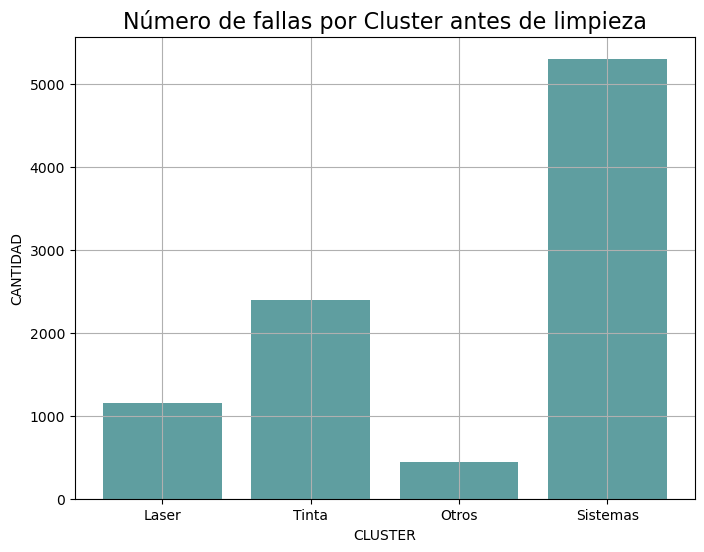

In [3]:
plt.figure(figsize=(8,6))
plt.grid()
plt.bar(['Laser', 'Tinta', 'Otros', 'Sistemas'], reparaciones.groupby('CLUSTER')['CLUSTER'].count(), color='cadetblue')
plt.title('Número de fallas por Cluster antes de limpieza', fontsize=16)
plt.xlabel('CLUSTER')
plt.ylabel('CANTIDAD')

### Distribución de las similitudes coseno

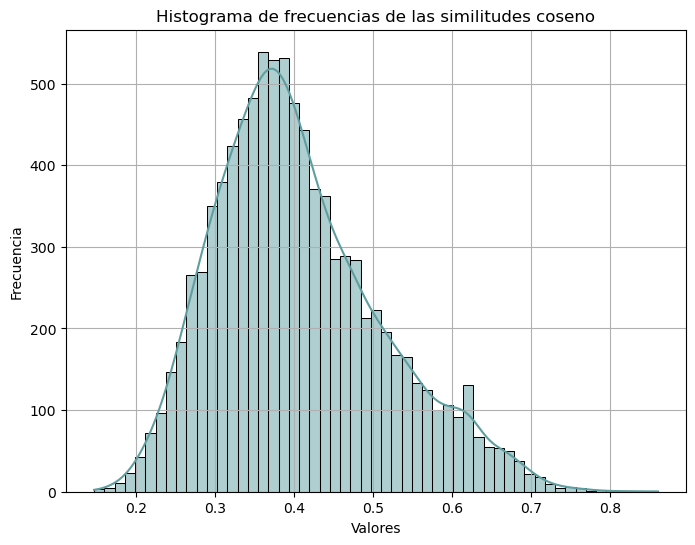

In [4]:
plt.figure(figsize=(8,6))
sns.histplot(reparaciones['SIMILITUD COSENO'], kde=True, color='cadetblue')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Histograma de frecuencias de las similitudes coseno')
plt.grid()

### Establecimiento del threshold

Decidimos limpar a partir del percentil ###, lo que significa que no nos interesan los registros que sean menores al percentil ###. Los que estén por encima del percentil ### no tenemos que eliminarlos porque esos representan a los que el modelo relacionó mejor.

In [5]:
threshold = reparaciones['SIMILITUD COSENO'].quantile(0.05)
threshold

0.25578981100000003

### Número de fallas fuera del threshold

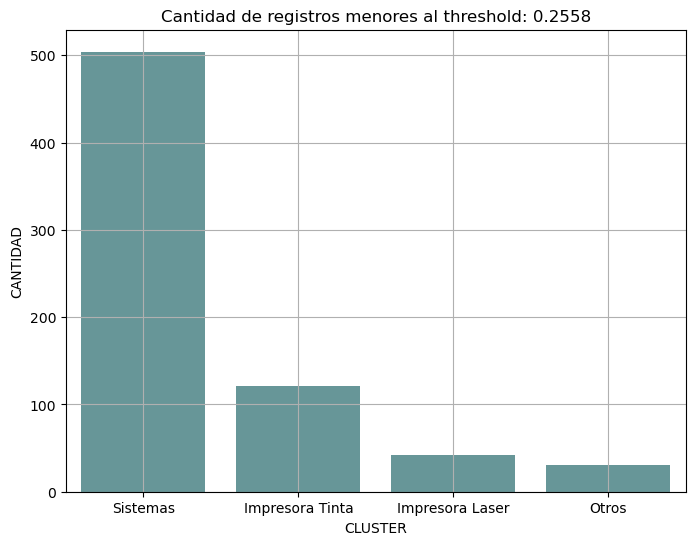

In [6]:
df_filtrado = reparaciones[reparaciones['SIMILITUD COSENO'] < 0.27]

conteo_clusters = df_filtrado['CLUSTER'].value_counts().reset_index()
conteo_clusters.columns = ['CLUSTER', 'cantidad']

plt.figure(figsize=(8,6))
sns.barplot(data=conteo_clusters, x='CLUSTER', y='cantidad', color = 'cadetblue')
plt.xlabel('CLUSTER')
plt.ylabel('CANTIDAD')
plt.title(f'Cantidad de registros menores al threshold: {threshold:.4f}')
plt.grid()

In [7]:
reparaciones_thresholded = reparaciones[reparaciones['SIMILITUD COSENO'] >= 0.27].reset_index()
reparaciones_thresholded = reparaciones_thresholded.drop(columns='index')
reparaciones_thresholded

,CLIENTE,COHORT,DESCRIPCION FALLA,INGRESO,FECHA REPARACION,CLUSTER,SIMILITUD COSENO
0,2,2017-11-22,revision general tndr cambio del panel de cont...,1820.0,29/11/2018,Impresora Laser,0.298307
1,2,2017-11-22,imprime negro tn mantenimiento iva,480.0,30/11/2018,Impresora Tinta,0.391361
2,2,2017-11-22,rev gral cartucho toner reparacion traccion de...,1030.0,02/01/2019,Impresora Laser,0.508475
3,2,2017-11-22,rev gral sin toner con cable de energia bue...,530.0,29/11/2018,Impresora Laser,0.493519
4,2,2017-11-22,rev gral sin toner cambio de contacto del ca...,480.0,29/11/2018,Impresora Laser,0.448675
...,...,...,...,...,...,...,...
8597,1835,2024-09-13,en el area del impime obscuro en doble cara ta...,2815.0,20/09/2024,Sistemas,0.325016
8598,1837,2024-09-13,no escanea no saca copias marca papel atascado...,3532.0,30/09/2024,Sistemas,0.275756
8599,1843,2024-09-24,marcaba error de fusor y luego error de escane...,4790.0,30/09/2024,Impresora Laser,0.458887
8600,1841,2024-09-20,arruga las hojas y se atora cambio de filmin...,2575.0,26/09/2024,Otros,0.408079


Text(0, 0.5, 'CANTIDAD')

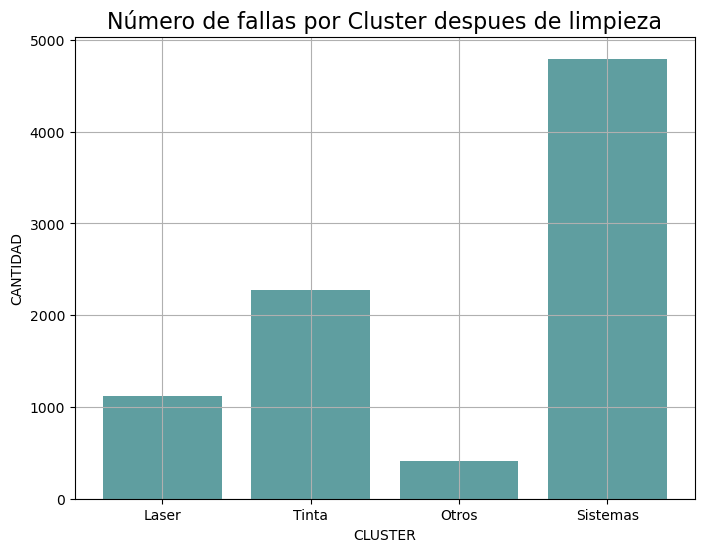

In [8]:
plt.figure(figsize=(8,6))
plt.grid()
plt.bar(['Laser', 'Tinta', 'Otros', 'Sistemas'], reparaciones_thresholded.groupby('CLUSTER')['CLUSTER'].count(), color='cadetblue')
plt.title('Número de fallas por Cluster despues de limpieza', fontsize=16)
plt.xlabel('CLUSTER')
plt.ylabel('CANTIDAD')

In [35]:
reparaciones = reparaciones_thresholded[['CLIENTE', 'COHORT', 'DESCRIPCION FALLA', 'INGRESO', 'FECHA REPARACION', 'CLUSTER']]

## Exploración de Datos 

In [36]:
reparaciones

,CLIENTE,COHORT,DESCRIPCION FALLA,INGRESO,FECHA REPARACION,CLUSTER
0,2,2017-11-22,revision general tndr cambio del panel de cont...,1820.0,29/11/2018,Impresora Laser
1,2,2017-11-22,imprime negro tn mantenimiento iva,480.0,30/11/2018,Impresora Tinta
2,2,2017-11-22,rev gral cartucho toner reparacion traccion de...,1030.0,02/01/2019,Impresora Laser
3,2,2017-11-22,rev gral sin toner con cable de energia bue...,530.0,29/11/2018,Impresora Laser
4,2,2017-11-22,rev gral sin toner cambio de contacto del ca...,480.0,29/11/2018,Impresora Laser
...,...,...,...,...,...,...
8597,1835,2024-09-13,en el area del impime obscuro en doble cara ta...,2815.0,20/09/2024,Sistemas
8598,1837,2024-09-13,no escanea no saca copias marca papel atascado...,3532.0,30/09/2024,Sistemas
8599,1843,2024-09-24,marcaba error de fusor y luego error de escane...,4790.0,30/09/2024,Impresora Laser
8600,1841,2024-09-20,arruga las hojas y se atora cambio de filmin...,2575.0,26/09/2024,Otros


In [37]:
reparaciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8602 entries, 0 to 8601
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CLIENTE            8602 non-null   int64  
 1   COHORT             8602 non-null   object 
 2   DESCRIPCION FALLA  8602 non-null   object 
 3   INGRESO            8602 non-null   float64
 4   FECHA REPARACION   8602 non-null   object 
 5   CLUSTER            8602 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 403.3+ KB


In [38]:
reparaciones['FECHA REPARACION'] = reparaciones['FECHA REPARACION'].str.replace('-', '/')
reparaciones['COHORT'] = reparaciones['COHORT'].str.replace('-', '/')

reparaciones['FECHA REPARACION'] = pd.to_datetime(reparaciones['FECHA REPARACION'], dayfirst=True, errors='coerce')
reparaciones['COHORT'] = pd.to_datetime(reparaciones['COHORT'], dayfirst=True, errors='coerce')

current_date = datetime.now()
reparaciones.loc[reparaciones['FECHA REPARACION'] > current_date, 'FECHA REPARACION'] = pd.NaT
reparaciones.loc[reparaciones['COHORT'] > current_date, 'COHORT'] = pd.NaT

reparaciones = reparaciones.dropna(subset='FECHA REPARACION')
reparaciones = reparaciones.dropna(subset='COHORT')

reparaciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8555 entries, 0 to 8601
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   CLIENTE            8555 non-null   int64         
 1   COHORT             8555 non-null   datetime64[ns]
 2   DESCRIPCION FALLA  8555 non-null   object        
 3   INGRESO            8555 non-null   float64       
 4   FECHA REPARACION   8555 non-null   datetime64[ns]
 5   CLUSTER            8555 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 467.9+ KB


## Análisis y cálculo de los KPIs

### Customer Life Time Value (24 Meses)

In [39]:
snapshot_date = reparaciones['FECHA REPARACION'].max()
snapshot_date

Timestamp('2024-10-18 00:00:00')

In [40]:
reparaciones['FECHA REPARACION'].min()

Timestamp('2017-12-04 00:00:00')

In [65]:
reparaciones['CUSTOMER_TENURE'] = (snapshot_date.year - reparaciones['FECHA REPARACION'].dt.year)*12 + (
    snapshot_date.month - reparaciones['FECHA REPARACION'].dt.month)

reparaciones['CUSTOMER_TENURE_ON_TRANSACTION'] = (
    reparaciones['FECHA REPARACION'].dt.year - reparaciones['COHORT'].dt.year)*12 + (
    reparaciones['FECHA REPARACION'].dt.month - reparaciones['COHORT'].dt.month
)

cltv_24_months = reparaciones[
    (reparaciones['CUSTOMER_TENURE'] > 24) &
    (reparaciones['CUSTOMER_TENURE_ON_TRANSACTION'] <= 24)
].groupby('CLIENTE')['INGRESO'].sum().reset_index()
cltv_24_months = cltv_24_months.rename(columns={'INGRESO':'LTV_24_MESES'})

cltv_nombres = cltv_24_months.merge(clientes, on='CLIENTE', how='inner') # Para poder observar los nombres de los clientes

cltv_24_months.sort_values('LTV_24_MESES', ascending=False).head(15)

,CLIENTE,LTV_24_MESES
20,26,187318.88
2,4,142495.80
63,77,137738.80
713,898,118767.60
11,17,108435.00
26,33,103620.00
44,55,98055.54
1054,1297,90384.80
14,20,89573.60
96,119,89408.00
